# Creating the grid, mask, and topography

## The Grid object

In [1]:
from roms_tools import Grid

We can create a ROMS grid, mask, and topography by creating an instance of the `Grid` class.

In [2]:
%%time

grid = Grid(
    nx=100,  # number of points in the x-direction (not including 2 boundary cells on either end)
    ny=100,  # number of points in the y-direction (not including 2 boundary cells on either end)
    size_x=1800,  # size of the domain in the x-direction (in km)
    size_y=2400,  # size of the domain in the y-direction (in km)
    center_lon=-10,  # longitude of the center of the domain
    center_lat=61,  # latitude of the center of the domain
    rot=20,  # rotation of the grid's x-direction from lines of constant longitude, with positive values being a counter-clockwise rotation
    topography_source="ETOPO5",  # data source to use for the topography
    smooth_factor=8,  # smoothing factor used in the domain-wide Gaussian smoothing of the topography, default: 8
    hmin=5,  # minimum ocean depth (in m), default: 5
    rmax=0.2,  # maximum slope parameter (in m), default: 0.2
)

CPU times: user 2.55 s, sys: 450 ms, total: 3 s
Wall time: 4.6 s


To visualize the grid we have just created, we can use the `.plot` method.

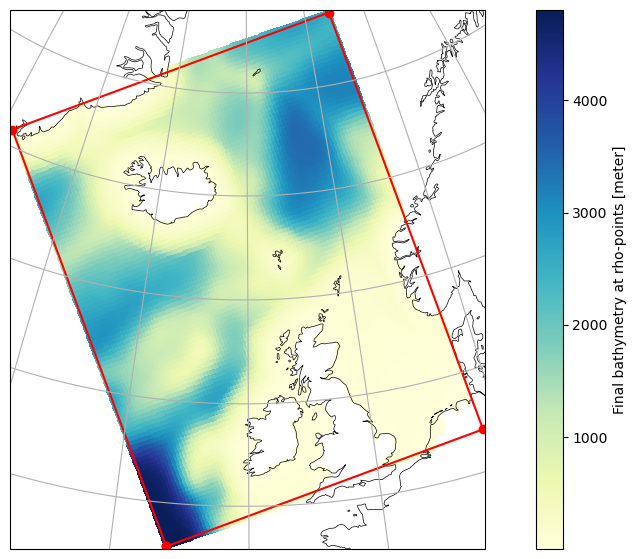

In [3]:
grid.plot(bathymetry=True)

To see the values of the grid variables, we can examine the `xarray.Dataset` object returned by the `.ds` property

In [4]:
grid.ds

<xarray.Dataset> Size: 1MB
Dimensions:   (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101)
Coordinates:
    lat_rho   (eta_rho, xi_rho) float64 83kB 47.84 47.91 47.97 ... 73.51 73.53
    lon_rho   (eta_rho, xi_rho) float64 83kB 344.0 344.3 344.5 ... 3.644 4.207
    lat_u     (eta_rho, xi_u) float64 82kB 47.87 47.94 48.0 ... 73.48 73.5 73.52
    lon_u     (eta_rho, xi_u) float64 82kB 344.2 344.4 344.6 ... 3.363 3.925
    lat_v     (eta_v, xi_rho) float64 82kB 47.94 48.0 48.07 ... 73.39 73.4 73.42
    lon_v     (eta_v, xi_rho) float64 82kB 344.0 344.2 344.4 ... 3.686 4.246
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables:
    angle     (eta_rho, xi_rho) float64 83kB 0.4177 0.4177 ... 0.1146 0.1146
    f         (eta_rho, xi_rho) float64 83kB 0.0001078 0.0001079 ... 0.0001395
    pm        (eta_rho, xi_rho) float64 83kB 4.209e-05 4.208e-05 ... 4.209e-05
    pn        (eta_rho, xi_rho) float64 83kB 5.592e-05 5.592e-05 ... 5.592e-05
    tra_lon   int64 8B -10
    tra_lat   int64 8B 61
    rotate    int64 8B 20
    hraw      (eta_rho, xi_rho) float64 83kB 4.759e+03 4.769e+03 ... 2.544e+03
    mask_rho  (eta_rho, xi_rho) float64 83kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    mask_u    (eta_rho, xi_u) float64 82kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    mask_v    (eta_v, xi_rho) float64 82kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    h         (eta_rho, xi_rho) float64 83kB 4.771e+03 4.771e+03 ... 2.524e+03
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev73+dirty
    size_x:              1800
    size_y:              2400
    topography_source:   ETOPO5
    smooth_factor:       8
    hmin:                5
    rmax:                0.2

Once we are happy with our grid, we can save it as a netCDF file via the `.save` method:

In [5]:
filepath = "/glade/derecho/scratch/noraloose/grids/my_roms_grid.nc"
grid.save(filepath)

We can also export the grid parameters to a YAML file.

In [6]:
yaml_filepath = "/glade/derecho/scratch/noraloose/grids/my_roms_grid.yaml"
grid.to_yaml(yaml_filepath)

This is the contents of the written YAML file.

In [7]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev73+dirty
---
Grid:
  center_lat: 61
  center_lon: -10
  hmin: 5
  nx: 100
  ny: 100
  rmax: 0.2
  rot: 20
  size_x: 1800
  size_y: 2400
  smooth_factor: 8
  topography_source: ETOPO5



The YAML file can help us to recreate the exact same grid object at a later point in time.

## Topography smoothing

### Domain-wide smoothing factor

The `smooth_factor` controls how much the original topography field is smoothed over the entire domain. Above we chose `smooth_factor = 8`, which is the default value. We can also choose a smaller value, say `smooth_factor = 2`, while leaving the other grid parameters unchanged.

In [8]:
%%time

grid_with_rougher_topo = Grid(
    nx=100,
    ny=100,
    size_x=1800,
    size_y=2400,
    center_lon=-10,
    center_lat=61,
    rot=20,
    smooth_factor=2,
)

CPU times: user 2.45 s, sys: 463 ms, total: 2.92 s
Wall time: 5.87 s


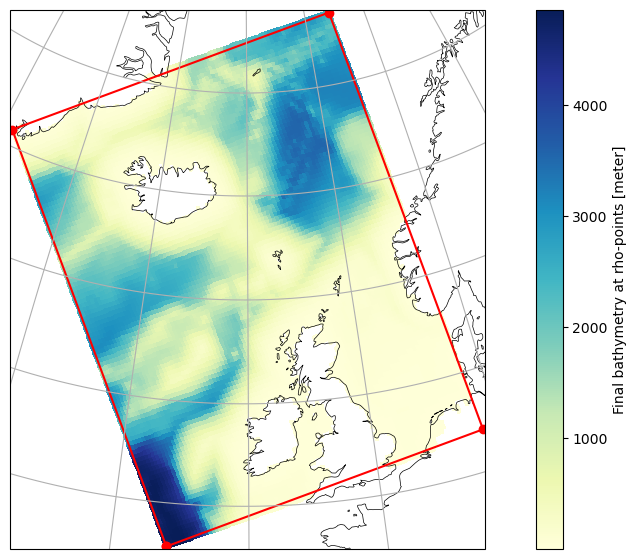

In [9]:
grid_with_rougher_topo.plot(bathymetry=True)

However, topography fields that are not smooth at the grid scale might lead to grid-scale noise in a ROMS simulation due to numerical instabilities. 

Before running a ROMS simulation, it is a good idea to check the smoothness of the topography by looking at its Laplacian. The `.compute_bathymetry_laplacian` method computes the Laplacian of the topography for us.

In [10]:
grid.compute_bathymetry_laplacian()
grid_with_rougher_topo.compute_bathymetry_laplacian()

The `xarray.Dataset` held by the `.ds` property has now a new data variable: `h_laplacian`

In [11]:
grid.ds

<xarray.Dataset> Size: 1MB
Dimensions:      (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101)
Coordinates:
    lat_rho      (eta_rho, xi_rho) float64 83kB 47.84 47.91 ... 73.51 73.53
    lon_rho      (eta_rho, xi_rho) float64 83kB 344.0 344.3 ... 3.644 4.207
    lat_u        (eta_rho, xi_u) float64 82kB 47.87 47.94 48.0 ... 73.5 73.52
    lon_u        (eta_rho, xi_u) float64 82kB 344.2 344.4 344.6 ... 3.363 3.925
    lat_v        (eta_v, xi_rho) float64 82kB 47.94 48.0 48.07 ... 73.4 73.42
    lon_v        (eta_v, xi_rho) float64 82kB 344.0 344.2 344.4 ... 3.686 4.246
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/13)
    angle        (eta_rho, xi_rho) float64 83kB 0.4177 0.4177 ... 0.1146 0.1146
    f            (eta_rho, xi_rho) float64 83kB 0.0001078 ... 0.0001395
    pm           (eta_rho, xi_rho) float64 83kB 4.209e-05 ... 4.209e-05
    pn           (eta_rho, xi_rho) float64 83kB 5.592e-05 ... 5.592e-05
    tra_lon      int64 8B -10
    tra_lat      int64 8B 61
    ...           ...
    hraw         (eta_rho, xi_rho) float64 83kB 4.759e+03 ... 2.544e+03
    mask_rho     (eta_rho, xi_rho) float64 83kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    mask_u       (eta_rho, xi_u) float64 82kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    mask_v       (eta_v, xi_rho) float64 82kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    h            (eta_rho, xi_rho) float64 83kB 4.771e+03 ... 2.524e+03
    h_laplacian  (eta_rho, xi_rho) float64 83kB nan nan nan nan ... nan nan nan
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev73+dirty
    size_x:              1800
    size_y:              2400
    topography_source:   ETOPO5
    smooth_factor:       8
    hmin:                5
    rmax:                0.2

We can compare the topography smoothness of the two grids by plotting the variable `h_laplacian`.

In [12]:
import matplotlib.pyplot as plt

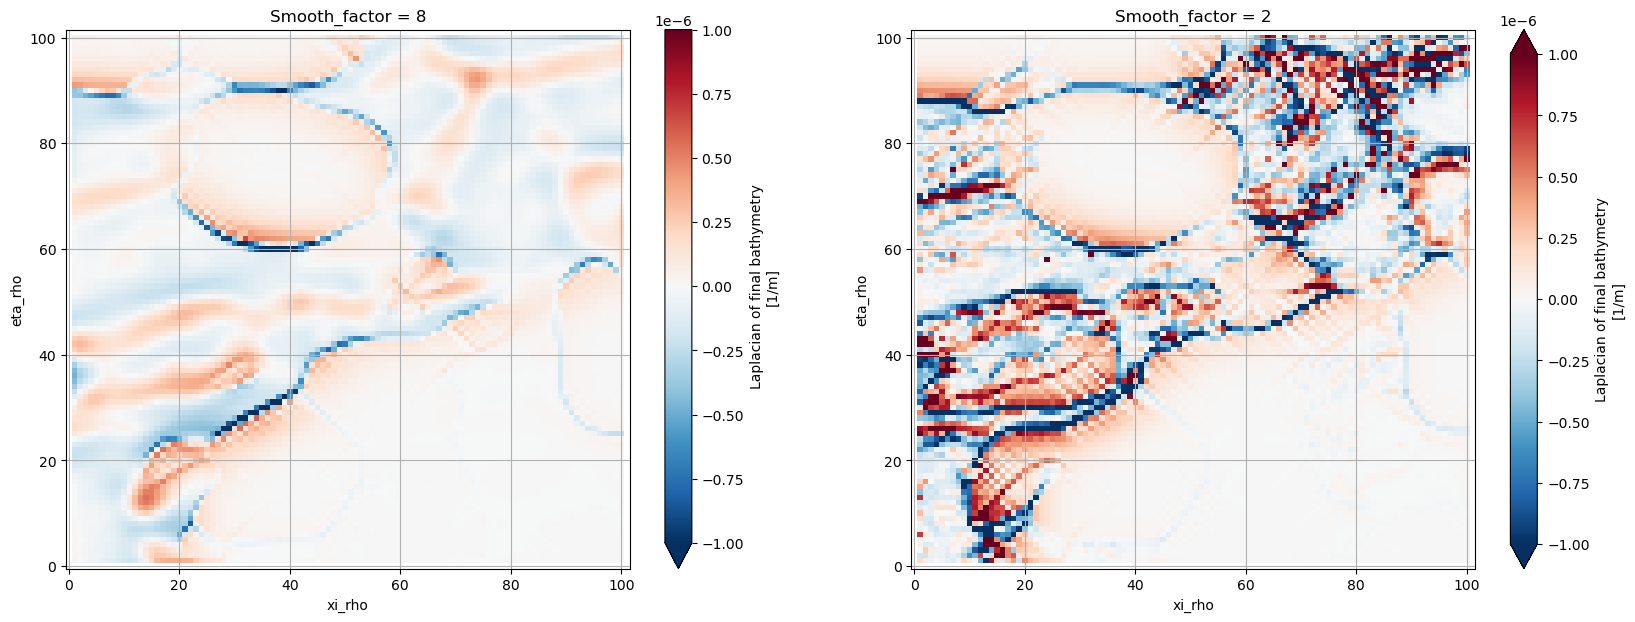

In [13]:
vmax = 1e-6

fig, axs = plt.subplots(1, 2, figsize=(20, 7))

for grid_plot, ax in zip([grid, grid_with_rougher_topo], axs):

    grid_plot.ds["h_laplacian"].plot(cmap="RdBu_r", vmax=vmax, vmin=-vmax, ax=ax)
    ax.set_title(f"Smooth_factor = {grid_plot.ds.smooth_factor}")
    ax.grid()

The plot on the right shows a lot of variability at the grid scale.

If you would like to pertain more bathymetric features while creating a topography field that is sufficiently smooth at the grid scale, it is always an option to increase the number of grid points.

### Slope parameter (or r-factor)
Besides the domain-wide smoothing discussed above, `ROMS-Tools` does additional local smoothing to satisfy the condition that the maximum slope parameter $r$ is smaller than the indicated `rmax`. The maximum slope parameter is given by
$$
   r = max\left(\frac{|\Delta_x h|}{  2h} , \frac{|\Delta_y h|}{  2h}\right).
$$
This additional local smoothing primarily occurs along the continental shelf. To show this, let's generate another topography field for the same grid, but with a larger value `rmax = 0.8`.

In [14]:
%%time

grid_with_larger_rmax = Grid(
    nx=100,
    ny=100,
    size_x=1800,
    size_y=2400,
    center_lon=-10,
    center_lat=61,
    rot=20,
    topography_source="ETOPO5",
    smooth_factor=8,
    hmin=5,
    rmax=0.8,
)

CPU times: user 705 ms, sys: 463 ms, total: 1.17 s
Wall time: 2.29 s


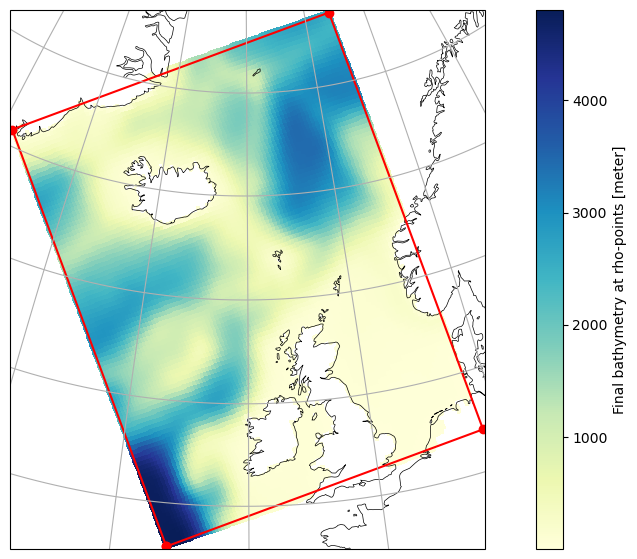

In [15]:
grid_with_larger_rmax.plot(bathymetry=True)

In the plot above we can see that the bathymetry along Iceland's coastline is not as shallow as for our original example, where we chose the default value `rmax = 0.2`. For direct comparison, here is the original example plotted again.

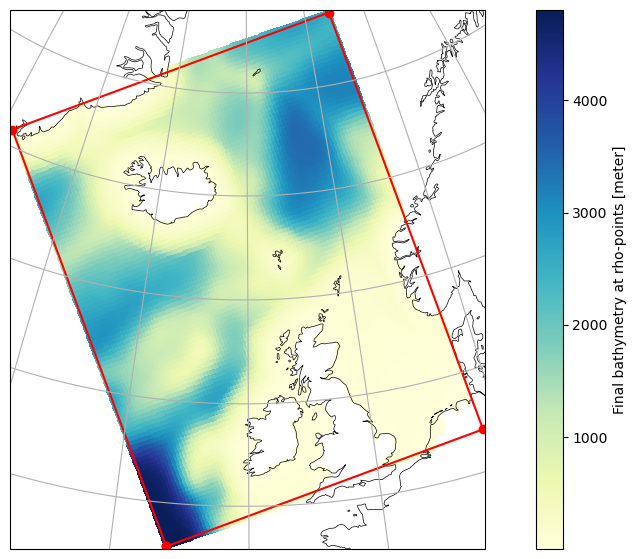

In [16]:
grid.plot(bathymetry=True)

## Creating a grid from an existing NetCDF or YAML file

We can also create a grid from an existing file.

In [17]:
filepath = "/glade/derecho/scratch/noraloose/grids/my_roms_grid.nc"
the_same_grid = Grid.from_file(filepath)

In [18]:
the_same_grid.ds

<xarray.Dataset> Size: 1MB
Dimensions:   (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101)
Coordinates:
    lat_rho   (eta_rho, xi_rho) float64 83kB ...
    lon_rho   (eta_rho, xi_rho) float64 83kB ...
    lat_u     (eta_rho, xi_u) float64 82kB ...
    lon_u     (eta_rho, xi_u) float64 82kB ...
    lat_v     (eta_v, xi_rho) float64 82kB ...
    lon_v     (eta_v, xi_rho) float64 82kB ...
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables:
    angle     (eta_rho, xi_rho) float64 83kB ...
    f         (eta_rho, xi_rho) float64 83kB ...
    pm        (eta_rho, xi_rho) float64 83kB ...
    pn        (eta_rho, xi_rho) float64 83kB ...
    tra_lon   int64 8B -10
    tra_lat   int64 8B 61
    rotate    int64 8B 20
    hraw      (eta_rho, xi_rho) float64 83kB ...
    mask_rho  (eta_rho, xi_rho) float64 83kB ...
    mask_u    (eta_rho, xi_u) float64 82kB ...
    mask_v    (eta_v, xi_rho) float64 82kB ...
    h         (eta_rho, xi_rho) float64 83kB ...
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev73+dirty
    size_x:              1800
    size_y:              2400
    topography_source:   ETOPO5
    smooth_factor:       8
    hmin:                5
    rmax:                0.2

Maybe we have changed our mind about how to smooth the topography. We can update the topography as follows:

In [19]:
the_same_grid.add_topography_and_mask(
    topography_source="ETOPO5",
    smooth_factor=16,
    hmin=5,
    rmax=0.2,
)

We still have the same grid, but now with a smoother topography.

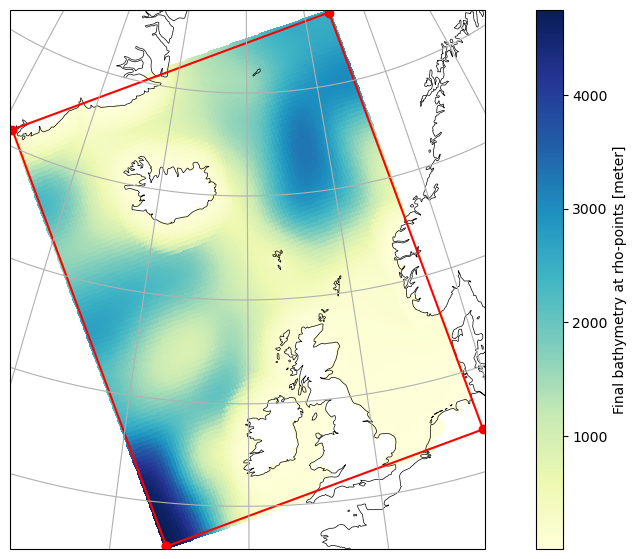

In [20]:
the_same_grid.plot(bathymetry=True)

In [21]:
new_filepath = "/glade/derecho/scratch/noraloose/grids/grid_with_smoother_topography.nc"
the_same_grid.save(new_filepath)

Alternatively, we can create a grid from an existing YAML file.

In [22]:
yaml_filepath = "/glade/derecho/scratch/noraloose/grids/my_roms_grid.yaml"
%time yet_the_same_grid = Grid.from_yaml(yaml_filepath)

CPU times: user 2.44 s, sys: 460 ms, total: 2.9 s
Wall time: 5.64 s


In [23]:
yet_the_same_grid.ds

<xarray.Dataset> Size: 1MB
Dimensions:   (eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101)
Coordinates:
    lat_rho   (eta_rho, xi_rho) float64 83kB 47.84 47.91 47.97 ... 73.51 73.53
    lon_rho   (eta_rho, xi_rho) float64 83kB 344.0 344.3 344.5 ... 3.644 4.207
    lat_u     (eta_rho, xi_u) float64 82kB 47.87 47.94 48.0 ... 73.48 73.5 73.52
    lon_u     (eta_rho, xi_u) float64 82kB 344.2 344.4 344.6 ... 3.363 3.925
    lat_v     (eta_v, xi_rho) float64 82kB 47.94 48.0 48.07 ... 73.39 73.4 73.42
    lon_v     (eta_v, xi_rho) float64 82kB 344.0 344.2 344.4 ... 3.686 4.246
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables:
    angle     (eta_rho, xi_rho) float64 83kB 0.4177 0.4177 ... 0.1146 0.1146
    f         (eta_rho, xi_rho) float64 83kB 0.0001078 0.0001079 ... 0.0001395
    pm        (eta_rho, xi_rho) float64 83kB 4.209e-05 4.208e-05 ... 4.209e-05
    pn        (eta_rho, xi_rho) float64 83kB 5.592e-05 5.592e-05 ... 5.592e-05
    tra_lon   int64 8B -10
    tra_lat   int64 8B 61
    rotate    int64 8B 20
    hraw      (eta_rho, xi_rho) float64 83kB 4.759e+03 4.769e+03 ... 2.544e+03
    mask_rho  (eta_rho, xi_rho) float64 83kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    mask_u    (eta_rho, xi_u) float64 82kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    mask_v    (eta_v, xi_rho) float64 82kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    h         (eta_rho, xi_rho) float64 83kB 4.771e+03 4.771e+03 ... 2.524e+03
Attributes:
    title:               ROMS grid created by ROMS-Tools
    roms_tools_version:  0.1.dev73+dirty
    size_x:              1800
    size_y:              2400
    topography_source:   ETOPO5
    smooth_factor:       8
    hmin:                5
    rmax:                0.2